# Tobig's 17기 2주차 Optimization 과제_나다경

# Gradient Descent 구현하기

### 1)"..."표시되어 있는 빈 칸을 채워주세요
### 2)강의내용과 코드에 대해 공부한 내용을 마크마운 또는 주석으로 설명해주세요

## 데이터

In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
data = pd.read_csv('assignment_2.csv')
data.head()

,Label,bias,experience,salary
0,1,1,0.7,48000
1,0,1,1.9,48000
2,1,1,2.5,60000
3,0,1,4.2,63000
4,0,1,6.0,76000


## Train Test 데이터 나누기

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0], test_size = 0.25, random_state = 0)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((150, 3), (50, 3), (150,), (50,))

## Scaling

experience와 salary의 단위, 평균, 분산이 크게 차이나므로 scaler를 사용해 단위를 맞춰줍니다. 

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
bias_train = X_train["bias"]
bias_train = bias_train.reset_index()["bias"]
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_train["bias"] = bias_train
X_train.head()

,bias,experience,salary
0,1,0.187893,-1.143335
1,1,1.185555,0.043974
2,1,-0.310938,-0.351795
3,1,-1.629277,-1.341220
4,1,-1.308600,0.043974


이때 scaler는 X_train에 fit 해주시고, fit한 scaler를 X_test에 적용시켜줍니다.  
똑같이 X_test에다 fit하면 안돼요!

In [7]:
bias_test = X_test["bias"]
bias_test = bias_test.reset_index()["bias"]
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
X_test["bias"] = bias_test
X_test.head()

,bias,experience,salary
0,1,-1.344231,-0.615642
1,1,0.508570,0.307821
2,1,-0.310938,0.571667
3,1,1.363709,1.956862
4,1,-0.987923,-0.747565


* bias는 절편을 구하기 위한 변수 -> 표준화 x

* experience & salary는 단위, 평균, 분산의 차이가 크게 남 -> 표준화

In [8]:
# parameter 개수
N = len(X_train.loc[0])

In [9]:
# 초기 parameter들을 임의로 설정해줍니다.
parameters = np.array([random.random() for i in range(N)])
random_parameters = parameters.copy()
parameters

array([0.56046353, 0.85744296, 0.77488327])

### * LaTeX   

Jupyter Notebook은 LaTeX 문법으로 수식 입력을 지원하고 있습니다.  
LaTeX문법으로 아래의 수식을 완성해주세요  
http://triki.net/apps/3466  
https://jjycjnmath.tistory.com/117

## Dot product
## $z = X_i \theta$

In [10]:
def dot_product(X, parameters):
    z = 0
    for i in range(len(parameters)):
        z += X[i] * parameters[i]
    return z

## Logistic Function

## $p = \frac{1}{1 + e^{-z}}$

* 로짓 함수는 [0,1] 범위를 입력 받아 전체 실수 범위의 값으로 변환

* 대조적으로 로지스틱 함수는 전체 실수 범위에 대한 입력 값을 가져와 [0,1] 범위의 값으로 변환

* 즉, 로지스틱 함수는 로짓 함수의 역함수로 특정 샘플이 클래스 1(또는 클래스 0)에 속할 조건부 확률을 예측할 수 있음.

In [11]:
def logistic(X, parameters):
    z = dot_product(X, parameters)
    p = 1 / (1 + np.exp(-z))    
    return p

In [12]:
logistic(X_train.iloc[1], parameters)

0.8335619066549693

## Object function

Object Function : 목적함수는 Gradient Descent를 통해 최적화 하고자 하는 함수입니다.  
<br>
**선형 회귀**의 목적함수
## $l(\theta) = \frac{1}{2}\Sigma(y_i - \theta^{T}X_i)^2$  
참고) $\hat{y_i} = \theta^{T}X_i$
  
**로지스틱 회귀**의 목적함수를 작성해주세요  
(선형 회귀의 목적함수처럼 강의에 나온대로 작성해주세요. **평균을 고려하는 것은 뒤에 코드에서 수행합니다)**
## $l(p) = - \Sigma(y_{i}logp(X_{i}) + (1-y_i)log(1-logp(X_{i})))$  

* 목적 함수는 보통 어떤 함수의 최댓값 또는 최솟값을 구하는 함수인데, 회귀에서 목적 함수는 평균 제곱 오차를 최소화하는 것

* 평균 제곱 오차를 최소로 만들 때 사용되는 기법이 경사하강법

* 그러나 로지스틱 회귀에서 평균 제곱 오차를 비용 함수로 사용하면, 경사 하강법을 사용하였을 때 찾고자 하는 최소값이 아닌 잘못된 최소값에 빠질 가능성이 매우 높음. 

* 이를 전체 함수에 걸쳐 최소값인 **글로벌 미니멈(Global Minimum)** 이 아닌 특정 구역에서의 최소값인 **로컬 미니멈(Local Minimum)** 에 도달했다고 함. 

* 로컬 미니멈에 지나치게 쉽게 빠지는 비용 함수는 cost가 가능한한 최소가 되는 가중치를 찾는다는 목적에는 좋지 않은 선택. -> 로지스틱 회귀에서의 평균 제곱 오차는 바로 그 좋지 않은 선택에 해당함.

* 로지스틱 회귀에서 찾아낸 비용 함수를 크로스 엔트로피 함수라고 함. 결론적으로 로지스틱 회귀는 비용 함수로 크로스 엔트로피 함수를 사용하며, 가중치를 찾기 위해서 크로스 엔트로피 함수의 평균을 취한 함수를 사용함.

In [13]:
def minus_log_cross_entropy_i(X, y, parameters):
    p = logistic(X, parameters)
    loss = (y*np.log(p) + (1-y)*np.log(1-p))
    return -loss

In [14]:
def mse_i(X, y, parameters):
    y_hat = np.dot(X, parameters.T)
    loss = (1/2) * ((y - y_hat)**2) 
    return loss

In [15]:
def batch_loss(X_set, y_set, parameters, loss_function, n): #n:현재 배치의 데이터 수
    loss = 0
    for i in range(X_set.shape[0]):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        loss += loss_function(X, y, parameters)
    loss = loss / n #loss 평균값으로 계산
    return loss

In [16]:
batch_loss(X_test, y_test, parameters, minus_log_cross_entropy_i, len(X_test))

1.374343666383798

In [17]:
batch_loss(X_test, y_test, parameters, mse_i, len(X_test))

1.7612555310705833

* 위 함수들은 각 데이터 셋에 대한 목적 함수, 시그마의 안쪽 부분을 의미하고 batch_loss를 통해 시그마를 시행 -> 전체의 목적 함수의 평균을 구함 

## Gradient
위의 선형회귀의 목적함수 $l(\theta)$와 로지스틱회귀의 목적함수 $l(p)$의 gradient를 작성해주세요  
(위의 목적함수를 참고해서 작성해주세요 = 평균을 고려하는 것은 뒤에 코드에서 수행합니다)

## ${\partial\over{\partial \theta_{j}}}l(\theta)= - \Sigma(y_{i} -\theta^{T}X_{i})X_{ij} $ 
## ${\partial\over{\partial \theta_j}}l(p)= - \Sigma(y_{i} -p_{i})X_{ij}$ 

* 하나의 데이터셋에 대한 목적 함수의 Gradient를 구하는 함수로 추후에 하나의 배치 데이터에 대한 전체의 Gradient를 구하고 구해진 Gradient를 바탕으로 parameter를 수정하는 과정을 거침

* 따라서 위 함수는 제일 처음으로 시행되는 Gradient를 구하는 함수로 볼 수 있음.

In [18]:
def get_gradient_ij(X, y, parameters, j, model):
    if model == 'linear':
        y_hat = np.dot(X, parameters.T)
        gradient = (y - y_hat) * X[j]
    else:
        p = logistic(X, parameters)
        gradient = (y - p) * X[j]
    return -gradient

In [19]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'logistic')

-0.10165064675438011

In [20]:
get_gradient_ij(X_train.iloc[0,:], y_train.iloc[0], parameters, 1, 'linear')

-0.21877890548887627

## Batch Gradient
하나의 배치 (X_set, y_set)에 대해 기울기를 구하는 코드를 작성해주세요

In [21]:
def batch_gradient(X_set, y_set, parameters, model):
    gradients = [0 for _ in range(len(parameters))]
    
    for i in range(len(X_set)):
        X = X_set.iloc[i,:]
        y = y_set.iloc[i]
        for j in range(len(parameters)):
            gradients[j] += get_gradient_ij(X, y, parameters, j, model)
    
    return gradients

In [22]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'logistic')
gradients1

[46.201202510032005, 20.449045931648207, 50.64912371963097]

In [23]:
gradients1 = batch_gradient(X_train, y_train, parameters, 'linear')
gradients1

[42.0695298412472, 196.8178445254023, 225.7586607953571]

## mini-batch
인덱스로 미니 배치 나누기

In [24]:
def batch_idx(X_train, batch_size):
    N = len(X_train)
    nb = (N // batch_size)+1 #number of batch
    idx = np.array([i for i in range(N)])
    idx_list = [idx[i*batch_size:(i+1)*batch_size] for i in range(nb) if len(idx[i*batch_size:(i+1)*batch_size]) != 0]
    return idx_list

In [25]:
batch_idx(X_train, 10)

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69]),
 array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109]),
 array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119]),
 array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129]),
 array([130, 131, 132, 133, 134, 135, 136, 137, 138, 139]),
 array([140, 141, 142, 143, 144, 145, 146, 147, 148, 149])]

batch_idx 함수에 대한 설명을 batch_size와 함께 간략하게 작성해주세요  
### 설명: batch_size는 한 번 학습할 때 활용되는 데이터 크기를 말함. batch_size가 1이면 한 번 학습할 때 전체 데이터 중 임의의 1개의 데이터만 학습함. 현재 X_train의 크기는 150이기에 batch_size가 150이면 1개의 데이터 셋이 만들어지고, batch_size가 10이면 15개의 데이터셋 크기가 만들어 진다. 즉, batch_size가 k이면 전체 데이터의 수 / k개 만큼의 데이터셋이 만들어지고 한 번 학습할 때 k개의 데이터가 활용된다. batch_size와 데이터셋 크기는 trade-off 관계에 있다.

## Update Parameters
기울기를 갱신하는 코드를 작성해주세요  
(loss와 마찬가지로 기울기를 갱신할 때 배치 사이즈를 고려해 평균으로 갱신해주세요)

* Gradient descent, 즉 경사를 따라가면서 cost를 최소화하는 단계에서 경사를 얼만큼씩 이동할건지 정해주는 것은 learning rate임. learning rate의 값을 정하는 것은 매우 중요함.

* learning rate가 매우 컸을 때, **overshooting**발생 가능함. learning rate가 너무 크면, 최솟값을 찾지 못하고, 왔다갔다 하고, 심지어 cost가 증가하는, 그래프에서 튕겨져 나가는 듯한 상황이 올 수 있음.

* **즉, cost를 최소화하는 함수에 있어서 cost가 줄어들지 않고 오히려 점점 늘어나는 현상이 있다면 learning rate를 의심해야 함.**

* learning rate가 매우 작을때는 cost의 변화가 매우 작아 그 최솟값을 찾는데 시간이 너무 오래 걸리는 등의 현상이 발생할 수 있음.

In [26]:
def step(parameters, gradients, learning_rate, n): #n:현재 배치의 데이터 수
    for i in range(len(parameters)):
        gradients[i] *= learning_rate/n
    
    parameters -= gradients
    return parameters

In [27]:
step(parameters, gradients1, 0.01, len(X_train))

array([0.5576589 , 0.84432177, 0.7598327 ])

* 위 함수는 구해진 Gradient를 바탕으로 설정한 학습률로 Gradient를 조정하고 그를 바탕으로 parameter를 수정하는 함수임.

## Gradient Descent
위에서 작성한 함수들을 조합해서 경사하강법 함수를 완성해주세요

- learning_rate: 학습률  
- tolerance: Step이 너무 작아서 더 이상의 학습이 무의미할 때 학습을 멈추는 조건  
- batch: 기울기를 1번 갱신할 때 사용하는 데이터셋  
- epoch: 현재 반복 횟수 
- num_epoch: 총 반복 횟수

<br>

BGD: 배치 경사 하강법으로 **모든 데이터**에 대하여 각각 Loss function을 계산하고, 그들의 기댓값을 오차로 하고, 그 오차를 최소화시키는 방향으로 weight를 업데이트 함. 초기 W 값에 매우 큰 영향을 받음. 연산에 대한 cost가 매우 커짐. 

SGD: 확률적 경사 하강법으로 **임의의 1개의 데이터**만 고려해 Loss function을 계산하고, 그 함수를 최소화하는 방향으로 weight를 업데이트 함. BGD보다는 global minimum으로 갈 가능성이 적으나 1개의 데이터를 이용해 gradient를 계산하기 때문에 Iteration이 매우 커지게 됨. 수렴하지 못하고 이상한 곳에서 왔다갔다 하는 문제가 발생할 수 있고, 수렴 속도가 매우 느림.

MGD: 미니배치 경사하강법으로 **미니 배치**를 만들어서 데이터셋 일부에 대해서만 BGD 방식으로 weight를 갱신함. 

<br>
batch_size에 따른 경사하강법의 종류를 적어주세요

batch_size=1 -> SGD 

batch_size=k -> MGD 

batch_size=whole -> BGD

In [28]:
def gradient_descent(X_train, y_train, learning_rate = 0.1, num_epoch = 1000, tolerance = 0.00001, model = 'logistic', batch_size = 16):
    stopper = False
    
    N = len(X_train.iloc[0])
    
    # train data의 독립변수의 수만큼 랜덤한 파라미터를 구함.
    parameters = np.random.rand(N)
    
    # 로지스틱 회귀라면 목적함수로 minus_log_cross_entropy_i를 사용하고 선형이라면 mse_i를 사용함.
    loss_function = minus_log_cross_entropy_i if model == 'logistic' else mse_i
    
    # 초기 손실함수를 아주 큰 값으로 설정함.
    loss = 999
    
    # 배치 사이즈에 맞는 데이터 셋을 구함.
    batch_idx_list = batch_idx(X_train, batch_size)
    
    # num_epoch만큼 학습 시행.
    for epoch in range(num_epoch):
        if stopper:
            break
        # 한 번 학습 때 사용할 데이터 셋을 구함.
        for idx in batch_idx_list:
            # 한 번 학습 때 사용하는 x, y 데이터
            X_batch = X_train.iloc[idx,]
            y_batch = y_train.iloc[idx]
            # 현재 학습에 활용되는 데이터의 gradient를 구함.
            gradients = batch_gradient(X_batch, y_batch, parameters, model)
            # 구한 gradient를 바탕으로 parameter 수정.
            parameters = step(parameters, gradients, learning_rate, len(X_batch))
            # 수정된 parameter를 바탕으로 새로운 손실함수 구함.
            new_loss = batch_loss(X_batch, y_batch, parameters, loss_function, len(X_batch))
            
            # 중단 조건
            # 새로운 손실 함수와 기존 손실 함수의 차이가 tolerance보다 작다면 학습을 중단
            # 왜냐하면 현재 데이터에 대하여 이미 충분히 학습을 완료했기에 더 이상의 학습이 필요없음.
            if abs(new_loss - loss) < tolerance:
                stopper = True
                break
            # 아니라면 최신의 제일 작은 손실함수로 변경
            loss = new_loss
        
        #100epoch마다 학습 상태 출력
        if epoch%100 == 0: #출력이 길게 나오면 check point를 수정해도 됩니다.
            print(f"epoch: {epoch}  loss: {new_loss}  params: {parameters}  gradients: {gradients}")
    
    return parameters

## Implement
경사하강법 함수를 이용해 최적의 모수 찾아보세요. 학습을 진행할 때, Hyper Parameter를 바꿔가면서 학습시켜보세요.

## Logistic Regression

* 배치 사이즈를 키우는 건 러닝 레이트를 줄이는 것과 동일한 효과를 나타냄.

* 하지만 배치 사이즈의 증가는 메모리가 허락하는 한 학습의 속도를 증가시키기 때문에 train data size의 감소보다 효율적임.

* learning rate를 고정한 후 BGD, SGD, MGD 방식으로 구현 

In [29]:
new_param_bgd = gradient_descent(X_train, y_train, batch_size = X_train.shape[0])
new_param_bgd

epoch: 0  loss: 0.8430740945127624  params: [0.56502411 0.46503346 0.09835313]  gradients: [0.03558450005178442, -7.717233058364212e-06, 0.019387320715102165]
epoch: 100  loss: 0.44236871346628903  params: [-0.81639022  0.96375404 -0.88269942]  gradients: [0.004159974052829117, -0.005814112821106385, 0.005991011383678516]
epoch: 200  loss: 0.38660754168047023  params: [-1.04515392  1.46372886 -1.37861564]  gradients: [0.0013511584565926431, -0.004269041086211396, 0.004169264236624506]
epoch: 300  loss: 0.3585191155604613  params: [-1.15127022  1.8348712  -1.73968253]  gradients: [0.0008788691751050966, -0.0032421938941984167, 0.0031428725662663855]
epoch: 400  loss: 0.3417763143406986  params: [-1.22945589  2.12317513 -2.01831729]  gradients: [0.0007045981517073811, -0.002574703308299415, 0.002480804816910228]
epoch: 500  loss: 0.3309048218938721  params: [-1.29403975  2.35602454 -2.24209264]  gradients: [0.0005941091321471083, -0.0021128888314612504, 0.0020253305713062446]
epoch: 600 

array([-1.50666271,  3.08577808, -2.93585042])

* BGD 방식은 한 번 학습할 때 전체 데이터를 사용하기 때문에 GPU를 통한 병렬처리가 가능해 속도가 빨라질 수 있지만 지역 최적화에 빠질 수 있고 비용이 많이 듦.

* 결과 향상을 위해서는 num_epoch를 증가시키거나 learning_rate 조정 필요 

In [30]:
new_param_sgd = gradient_descent(X_train, y_train, batch_size = 1)
new_param_sgd

epoch: 0  loss: 0.27647779248511634  params: [-0.88423834  1.07430196 -1.20041478]  gradients: [0.024984273465832027, 0.013596465516766057, 0.01757870350089843]
epoch: 100  loss: 0.0773667215652323  params: [-1.9303256   4.17501927 -4.06769092]  gradients: [0.0075385440651282555, 0.004102482890619623, 0.005304049810797012]
epoch: 200  loss: 0.07736266552219787  params: [-1.9303681   4.1751431  -4.06780374]  gradients: [0.00753815952186717, 0.004102273621809138, 0.005303779249718695]
epoch: 300  loss: 0.07736266518361727  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.0075381594897671435, 0.004102273604340272, 0.005303779227133413]
epoch: 400  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 500  loss: 0.07736266518359017  params: [-1.9303681   4.17514311 -4.06780375]  gradients: [0.007538159489764571, 0.004102273604338872, 0.005303779227131603]
epoch: 600  loss: 0

array([-1.9303681 ,  4.17514311, -4.06780375])

* SGD 방식은 한 번 학습할 때 하나의 데이터를 활용하기 때문에 GPU를 통한 병렬처리가 불가능해 속도가 느려질 수 있지만 지역 최적화에 빠질 우려가 BGD보다는 적음.

* 손실 함수가 가장 작음.

* 결과 향상을 위해서는 num_epoch를 증가시키거나 learning_rate 조정 필요 

In [31]:
new_param_mgd = gradient_descent(X_train, y_train, batch_size = 30)
new_param_mgd

epoch: 0  loss: 0.8537777109226673  params: [ 0.62305678  0.37251276 -0.0296035 ]  gradients: [0.03380072665317999, 0.008328560061407813, 0.03139732986066195]
epoch: 100  loss: 0.32699946723185325  params: [-1.29372963  2.35847955 -2.24775995]  gradients: [-0.00030561031639523276, 0.0007956230596434618, 0.006697762776874057]
epoch: 200  loss: 0.2963973702379448  params: [-1.50682427  3.08740893 -2.94033131]  gradients: [0.0011923231899555987, 0.001595043977370259, 0.004573963695356216]
epoch: 300  loss: 0.28628099973975313  params: [-1.62550619  3.47946555 -3.30822284]  gradients: [0.0019752943655709783, 0.0019217929853666824, 0.0036936235877184816]
epoch: 400  loss: 0.28172586052425347  params: [-1.69953243  3.72140221 -3.53370338]  gradients: [0.0024429088938002458, 0.0020960376420483067, 0.003219451407521687]
epoch: 500  loss: 0.2793332685792222  params: [-1.7485018   3.88064362 -3.68149436]  gradients: [0.0027428793483987935, 0.0022008500510166673, 0.002932007202425716]
epoch: 600 

array([-1.84246846,  4.18477668, -3.96244711])

* MGD 방식은 한 번 학습할 때 30개의 데이터를 사용하기 때문에 GPU를 통한 병렬처리가 가능해 SGD보다는 빠르고 BGD보다는 속도가 느린 방식임.

* 하지만 BGD보다 지역 최적화에 빠질 우려가 적고 2번째로 작은 손실함수를 보여줌.

* 결과 향상을 위해서는 num_epoch를 증가시키거나 learning_rate 조정 필요함.

### Predict Label

In [32]:
# new_param_bgd를 활용한 에측
y_predict_bgd = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_bgd)
    if p> 0.5 :
        y_predict_bgd.append(1)
    else :
        y_predict_bgd.append(0)

# 초기 설정된 random_parameters를 활용한 예측        
y_predict_random = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], random_parameters)
    if p> 0.5 :
        y_predict_random.append(1)
    else :
        y_predict_random.append(0)

# 추가
# new_param_sgd를 활용한 예측
y_predict_sgd = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_sgd)
    if p> 0.5 :
        y_predict_sgd.append(1)
    else :
        y_predict_sgd.append(0)
        
# new_param_mgd를 활용한 예측
y_predict_mgd = []
for i in range(len(y_test)):
    p = logistic(X_test.iloc[i,:], new_param_mgd)
    if p> 0.5 :
        y_predict_mgd.append(1)
    else :
        y_predict_mgd.append(0)

* 임계치 0.5를 기준으로 로지스틱 함수로 예측한 확률 값을 0과 1로 구분한 코드임.

### Confusion Matrix

In [33]:
from sklearn.metrics import *

In [34]:
def get_clf_eval(y_test, y_predict, title):
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    print(f'{title}의 Confusion Matrix')
    confusion_matrix(y_test, y_predict)
    accuracy = (tp+tn) / (tp+fn+fp+tn)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2 * (precision*recall) / (precision + recall)
    print(f'{title}의 accuracy : {accuracy:.5f}, precision : {precision:.5f}, recall : {recall:.5f}, f1 : {f1:.5f}')
    print()

In [35]:
get_clf_eval(y_test, y_predict_bgd, 'y_predict_bgd')
get_clf_eval(y_test, y_predict_sgd, 'y_predict_sgd')
get_clf_eval(y_test, y_predict_mgd, 'y_predict_mgd')
get_clf_eval(y_test, y_predict_random, 'y_predict_random')

y_predict_bgd의 Confusion Matrix
y_predict_bgd의 accuracy : 0.88000, precision : 0.75000, recall : 0.60000, f1 : 0.66667

y_predict_sgd의 Confusion Matrix
y_predict_sgd의 accuracy : 0.94000, precision : 0.81818, recall : 0.90000, f1 : 0.85714

y_predict_mgd의 Confusion Matrix
y_predict_mgd의 accuracy : 0.94000, precision : 0.81818, recall : 0.90000, f1 : 0.85714

y_predict_random의 Confusion Matrix
y_predict_random의 accuracy : 0.44000, precision : 0.25000, recall : 0.90000, f1 : 0.39130



In [38]:
print('전체 데이터의 개수: ', y_test.count())
print("0의 개수          : ",sum(y_test == 0))
print("1의 개수          : ",sum(y_test == 1))

전체 데이터의 개수:  50
0의 개수          :  40
1의 개수          :  10


임계치 0.5를 기준으로 예측한 값에 대한 Confusion Matrix, accuracy, precision, recall, f1 score를 구한 코드임. test의 데이터 라벨이 8:2의 비율로 0에 치우져진 불균형한 상태임. 따라서 모든 값을 0으로 예측해도 정확도가 높아지기 때문에 정확도는 평가하기에 좋은 지표라고 볼 수는 없음.

SGD, MGD 방식으로 학습한 데이터의 성능이 비교적 좋게 나왔음.

## Linear regression
### $y = 0.5 + 2.7x$

### Data

In [39]:
raw_X = np.random.rand(150)
y = 2.7*raw_X + 0.5 + np.random.randn(150)

In [40]:
tmp = np.array([1 for _ in range(150)])
X = np.vstack((tmp, raw_X)).T
X = pd.DataFrame(X)
y = pd.Series(y)

### Estimation

In [41]:
# 정규방정식
theta = np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)
theta

array([0.79593572, 2.20593858])

In [42]:
# 경사하강법
new_param = gradient_descent(X, y, model='linear')
new_param

epoch: 0  loss: 0.31424336894729005  params: [1.28441686 0.70404877]  gradients: [0.0687318459465774, 0.036888050574125454]
epoch: 100  loss: 0.5271943673145046  params: [0.75067703 2.09588071]  gradients: [0.0791207446762681, 0.0522587982304327]
epoch: 200  loss: 0.5273412649042827  params: [0.74998289 2.09720209]  gradients: [0.07910930947509084, 0.05226382454738848]
epoch: 300  loss: 0.527341413184427  params: [0.74998219 2.09720342]  gradients: [0.07910929793793818, 0.052263829618517985]
epoch: 400  loss: 0.5273414133340294  params: [0.74998219 2.09720342]  gradients: [0.07910929792629816, 0.05226382962363433]
epoch: 500  loss: 0.5273414133341799  params: [0.74998219 2.09720342]  gradients: [0.07910929792628643, 0.052263829623639485]
epoch: 600  loss: 0.5273414133341803  params: [0.74998219 2.09720342]  gradients: [0.07910929792628639, 0.0522638296236395]
epoch: 700  loss: 0.5273414133341803  params: [0.74998219 2.09720342]  gradients: [0.07910929792628639, 0.0522638296236395]
epoc

array([0.74998219, 2.09720342])

In [43]:
y_hat_NE = theta.dot(X.T)
y_hat_GD = new_param.dot(X.T)

### Visualization
시각화를 통해 정규방정식과 경사하강법을 통한 선형회귀를 비교해보세요  
(밑의 코드를 실행만 시키면 됩니다. 추가 코드 x)

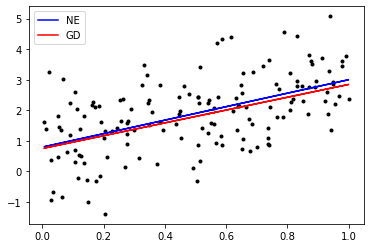

In [44]:
import matplotlib.pyplot as plt
plt.plot(X.iloc[:,1], y, '.k') #산점도
plt.plot(X.iloc[:,1], y_hat_NE, '-b', label = 'NE') #정규방정식
plt.plot(X.iloc[:,1], y_hat_GD, '-r', label = 'GD') #경사하강법
plt.legend()
plt.show()

정규방정식으로 구한 회귀선과 경사하강법으로 구한 회귀선 모두 비슷한 형태를 보이기 때문에 대체적으로 값을 잘 예측함.